In [1]:
import torch
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torchvision import transforms
from datasets import AugMixDataset
import augmentations
import matplotlib.pyplot as plt

In [2]:
# these are NOT the actual mean/std for this dataset, these are for the normal imagenet
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(64),
    transforms.RandomHorizontalFlip()
])
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])
# removing the normalization transform for visualization
preprocess_display = transforms.Compose([
    transforms.ToTensor()
])
test_transform_preprocess = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    preprocess,
])
train_dataset_display = AugMixDataset(ImageFolder("../tiny-imagenet-200/train"),
                                      preprocess_display,
                                      augmentations.augmentations_all)

class: 0


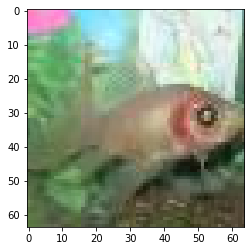

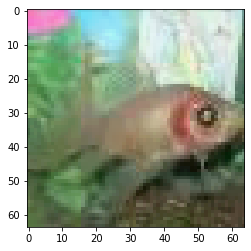

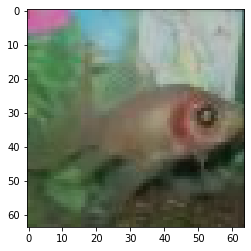

In [3]:
(clean, aug1, aug2), target = train_dataset_display[0]
print('class:', target)
plt.imshow(clean.permute(1, 2, 0))
plt.show()
plt.imshow(aug1.permute(1, 2, 0))
plt.show()
plt.imshow(aug2.permute(1, 2, 0))
plt.show()

The AugMix paper had the dataset produce 2 modified images for each clean image, and then added a Jensen-Shannon divergence loss term to penalize the model for producing different class probabilities for the clean and augmented images. Below is essentially a copy of their training loop. Notice that they only computed cross entropy loss for the clean images. The AugMixDataset object can instead be used to only generate augmented images by setting the fourth argument of its \__init__ method to True

In [ ]:
if no_jsd:
    images = images.cuda()
    targets = targets.cuda()
    logits = net(images)
    loss = F.cross_entropy(logits, targets)
else:
    images_all = torch.cat(images, 0).cuda()
    targets = targets.cuda()
    logits_all = net(images_all)
    logits_clean, logits_aug1, logits_aug2 = torch.split(logits_all, images[0].size(0))

  # Cross-entropy is only computed on clean images
    loss = F.cross_entropy(logits_clean, targets)

    p_clean = F.softmax(logits_clean, dim=1)
    p_aug1 = F.softmax(logits_aug1, dim=1)
    p_aug2 = F.softmax(logits_aug2, dim=1)

  # Clamp mixture distribution to avoid exploding KL divergence
    p_mixture = torch.clamp((p_clean + p_aug1 + p_aug2) / 3., 1e-7, 1).log()
    loss += 12 * (F.kl_div(p_mixture, p_clean, reduction='batchmean') +
                  F.kl_div(p_mixture, p_aug1, reduction='batchmean') +
                  F.kl_div(p_mixture, p_aug2, reduction='batchmean')) / 3.

In [4]:
train_dataset_display = AugMixDataset(ImageFolder("../tiny-imagenet-200/train"),
                                      preprocess_display,
                                      augmentations.augmentations_all,
                                      no_jsd=True)

class: 0


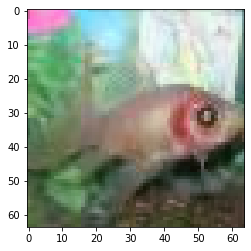

In [5]:
aug, target = train_dataset_display[0]
print('class:', target)
plt.imshow(aug.permute(1, 2, 0))
plt.show()